In [1]:
import xarray as xr
import xwmb
import matplotlib.pyplot as plt

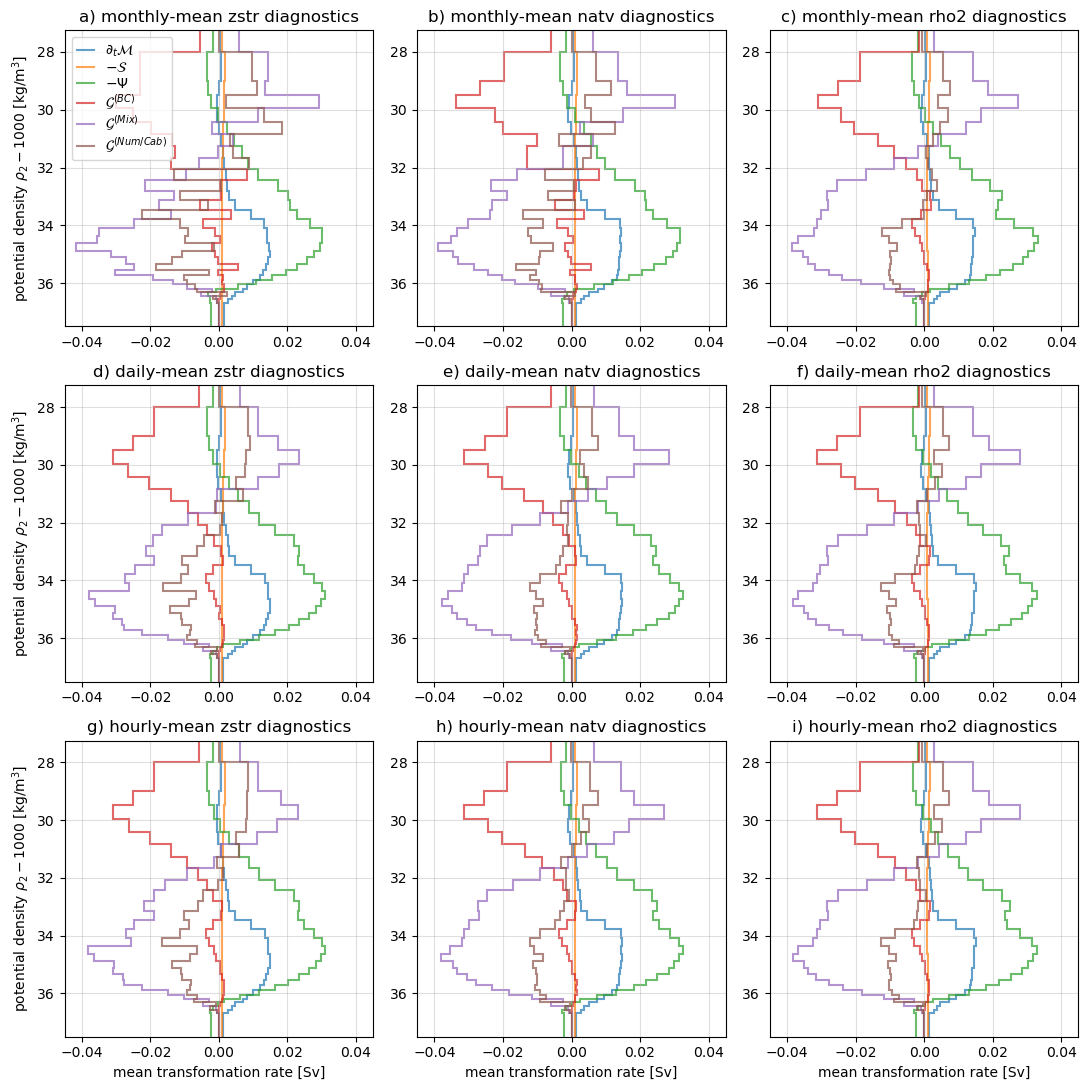

In [5]:
toSv = 1/1035. * 1e-6

labels = ["a)", "b)", "c)", "d)", "e)", "f)", "g)", "h)", "i)"]
kwargs = {"units":"Sv", "alpha":0.7, "lw":1.5}

fig, axes = plt.subplots(3,3,figsize=(11,11))
i = 0
for dt in ["monthly", "daily", "hourly"]:
    for gridname in ["zstr", "natv", "rho2"]:
        wmt = xr.open_dataset(f"data/baltic_wmb_sigma2_{gridname}_{dt}.nc")
        wmt_mean = wmt.mean('time')*toSv
        
        ax = axes.flatten()[i]
        plt.sca(ax)
        xwmb.stairs( wmt_mean, 'mass_tendency',             label=r"$\partial_{t} \mathcal{M}$",**kwargs)
        xwmb.stairs(-wmt_mean, 'mass_source',               label=r"$-\mathcal{S}$",            **kwargs)
        xwmb.stairs(-wmt_mean, 'overturning',               label=r"$-\Psi$",                   **kwargs)
        xwmb.stairs( wmt_mean, 'boundary_fluxes',           label=r"$\mathcal{G}^{(BC)}$",      **kwargs)
        xwmb.stairs( wmt_mean, 'diffusion',                 label=r"$\mathcal{G}^{(Mix)}$",     **kwargs)
        xwmb.stairs( wmt_mean, 'spurious_numerical_mixing', label=r"$\mathcal{G}^{(Num/Cab)}$", **kwargs)
        plt.ylabel(r"potential density $\rho_{2} - 1000$ [kg/m$^{3}$]");

        if i==0:
            plt.legend(loc="upper left", handlelength=1.2, labelspacing=0.12)
        if gridname != "zstr":
            plt.ylabel("")
        if dt != "hourly":
            plt.xlabel("")
        plt.grid(True, alpha=0.4)
        plt.title(f"{labels[i]} {dt}-mean {gridname} diagnostics")
        plt.ylim(37.5, 27.25);
        plt.xlim(-0.045, 0.045)
        i+=1
plt.tight_layout()
plt.savefig("figures/offline_budget_convergence_sigma2.png", bbox_inches="tight", dpi=150)

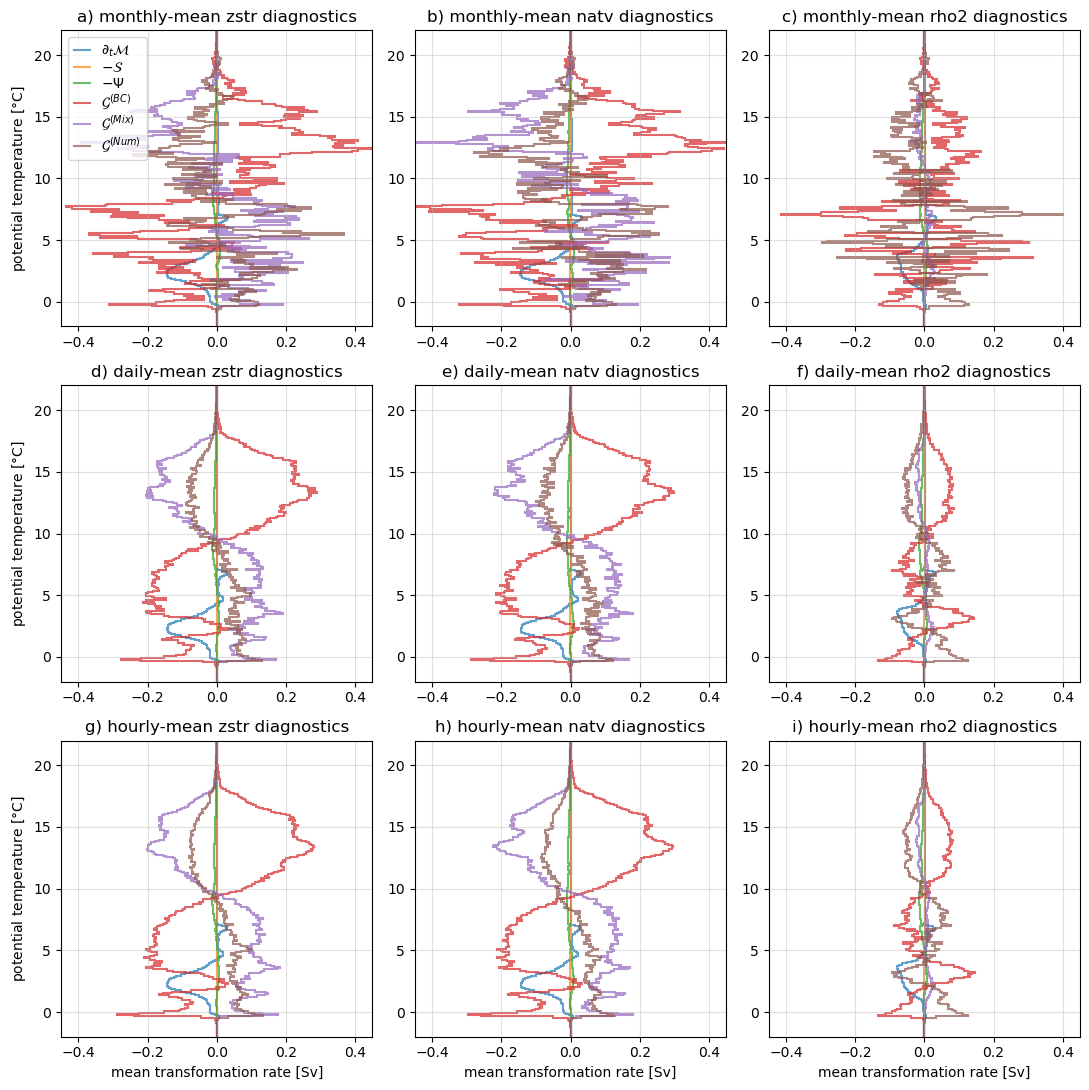

In [4]:
fig, axes = plt.subplots(3,3,figsize=(11,11))
i = 0
for dt in ["monthly", "daily", "hourly"]:
    for gridname in ["zstr", "natv", "rho2"]:
        wmt = xr.open_dataset(f"data/baltic_wmb_heat_{gridname}_{dt}.nc")
        wmt_mean = wmt.mean('time')*toSv
        
        ax = axes.flatten()[i]
        plt.sca(ax)
        xwmb.stairs( wmt_mean, 'mass_tendency',             label=r"$\partial_{t} \mathcal{M}$",**kwargs)
        xwmb.stairs(-wmt_mean, 'mass_source',               label=r"$-\mathcal{S}$",            **kwargs)
        xwmb.stairs(-wmt_mean, 'overturning',               label=r"$-\Psi$",                   **kwargs)
        xwmb.stairs( wmt_mean, 'boundary_fluxes',           label=r"$\mathcal{G}^{(BC)}$",      **kwargs)
        xwmb.stairs( wmt_mean, 'diffusion',                 label=r"$\mathcal{G}^{(Mix)}$",     **kwargs)
        xwmb.stairs( wmt_mean, 'spurious_numerical_mixing', label=r"$\mathcal{G}^{(Num)}$", **kwargs)
        plt.ylabel(r"potential temperature [$\degree$C]");

        if i==0:
            plt.legend(loc="upper left", handlelength=1.2, labelspacing=0.12)
        if gridname != "zstr":
            plt.ylabel("")
        if dt != "hourly":
            plt.xlabel("")
        plt.grid(True, alpha=0.4)
        plt.title(f"{labels[i]} {dt}-mean {gridname} diagnostics")
        plt.ylim(-2, 22);
        plt.xlim(-0.45, 0.45)
        i+=1
plt.tight_layout()
plt.savefig("figures/offline_budget_convergence_heat.png", bbox_inches="tight", dpi=150)